# Classificador de tênis (Nike vs Adidas)

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## Carregamento de dados dos datasets.

In [17]:
def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    '''''''''
    transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomResizedCrop(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
   
])
    '''''''''

    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    val_dir = os.path.join(data_dir, "Validation")

    train_data = ImageFolder(root=train_dir, transform=transform)
    test_data = ImageFolder(root=test_dir, transform=transform)
    val_data = ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [18]:
data_dir = "Dataset"
train_loader, test_loader, val_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(train_loader.dataset.classes)
print(device)

cuda:0


In [19]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
print(f"Número de amostras de validação: {len(val_loader.dataset)}")
print("Classes no conjunto de treinamento:")
print(train_loader.dataset.classes)

Número de amostras de treinamento: 459
Número de amostras de teste: 50
Número de amostras de validação: 55
Classes no conjunto de treinamento:
['adidas', 'nike']


In [20]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, num_classes)
resnet = resnet.to(device)

c:\Users\jhona\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [21]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [22]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### F1 Score

In [23]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return f1_score(true_labels, predicted_labels, average='macro')

### ROC AUC métrica

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_roc_auc_score(model, loader, n_classes):
    model.eval()
    true_labels = []
    predicted_probs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
    true_labels = label_binarize(true_labels, classes=[i for i in range(n_classes)])
    return roc_auc_score(true_labels, predicted_probs, multi_class='ovr')

### Validação

In [25]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss +=loss
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [26]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [27]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [28]:
import matplotlib.pyplot as plt

def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)
            loss += l1_reg
            l2_reg = l2_regularization(model, l2_lambda, device)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validation(model, testloader, criterion)
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1} | Loss: {train_losses[-1]} | Val Loss: {val_loss}')
    
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()


## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 70%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 76%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,00001. **Acurácia de 90%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.0001
l2_lambda = 0.0001
epochs = 30

## Treinamento

100%|██████████| 39/39 [00:09<00:00,  4.13it/s]


Epoch: 1 | Loss: 27.266901505299103 | Val Loss: 0.5214037895202637


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 2 | Loss: 25.802185498751125 | Val Loss: 0.4264658987522125


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


Epoch: 3 | Loss: 24.443267333201874 | Val Loss: 0.3783147931098938


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


Epoch: 4 | Loss: 23.12029398404635 | Val Loss: 0.6595245599746704


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


Epoch: 5 | Loss: 21.812169001652645 | Val Loss: 0.23392663896083832


100%|██████████| 39/39 [00:08<00:00,  4.49it/s]


Epoch: 6 | Loss: 20.734180108094826 | Val Loss: 0.42991524934768677


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


Epoch: 7 | Loss: 19.712811690110428 | Val Loss: 0.6790515780448914


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


Epoch: 8 | Loss: 18.811640763894104 | Val Loss: 0.5027623176574707


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


Epoch: 9 | Loss: 17.902931262285282 | Val Loss: 0.14815251529216766


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


Epoch: 10 | Loss: 17.157170320168518 | Val Loss: 0.1516495794057846


100%|██████████| 39/39 [00:08<00:00,  4.48it/s]


Epoch: 11 | Loss: 16.313358844854893 | Val Loss: 0.33658355474472046


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 12 | Loss: 15.522941515995907 | Val Loss: 0.4219690263271332


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


Epoch: 13 | Loss: 14.937717266571827 | Val Loss: 0.45973333716392517


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 14 | Loss: 14.339302943303036 | Val Loss: 0.32329070568084717


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 15 | Loss: 13.659904797871908 | Val Loss: 0.20006118714809418


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 16 | Loss: 13.086994317861704 | Val Loss: 0.08051648736000061


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 17 | Loss: 12.970191368689903 | Val Loss: 0.24734099209308624


100%|██████████| 39/39 [00:08<00:00,  4.43it/s]


Epoch: 18 | Loss: 12.309158985431377 | Val Loss: 0.12146254628896713


100%|██████████| 39/39 [00:08<00:00,  4.44it/s]


Epoch: 19 | Loss: 11.841972889044346 | Val Loss: 0.28693732619285583


100%|██████████| 39/39 [00:08<00:00,  4.39it/s]


Epoch: 20 | Loss: 11.302864539317596 | Val Loss: 0.13496249914169312


100%|██████████| 39/39 [00:08<00:00,  4.44it/s]


Epoch: 21 | Loss: 11.234852448487894 | Val Loss: 0.5186427235603333


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 22 | Loss: 10.726222013815855 | Val Loss: 0.4506300985813141


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


Epoch: 23 | Loss: 10.195316363603641 | Val Loss: 0.6255006194114685


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 24 | Loss: 9.845520997658754 | Val Loss: 0.3235354423522949


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


Epoch: 25 | Loss: 9.841376524705153 | Val Loss: 1.275870680809021


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 26 | Loss: 9.447869716546474 | Val Loss: 0.3034002184867859


100%|██████████| 39/39 [00:08<00:00,  4.46it/s]


Epoch: 27 | Loss: 9.352715100997534 | Val Loss: 0.5470214486122131


100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


Epoch: 28 | Loss: 8.989498016161797 | Val Loss: 0.1892819106578827


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


Epoch: 29 | Loss: 8.685396121098446 | Val Loss: 1.115989327430725


100%|██████████| 39/39 [00:08<00:00,  4.45it/s]


Epoch: 30 | Loss: 8.26558230473445 | Val Loss: 0.18931718170642853


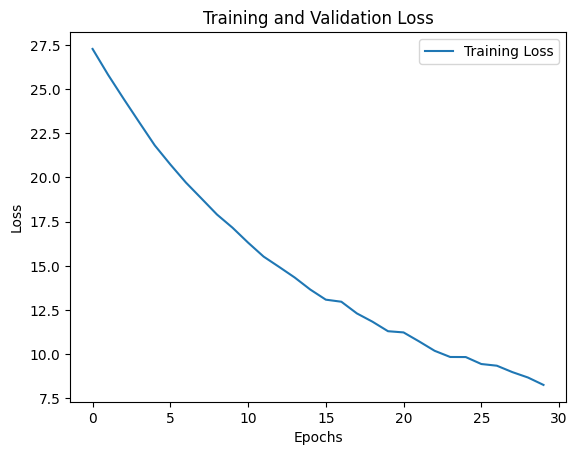

In [30]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda)

## Métricas de avaliação

### Recall

A rede atinge: 88% de acurácia
A rede atinge: 87.82% de recall
A rede atinge: 100.0% de ROC AUC Score


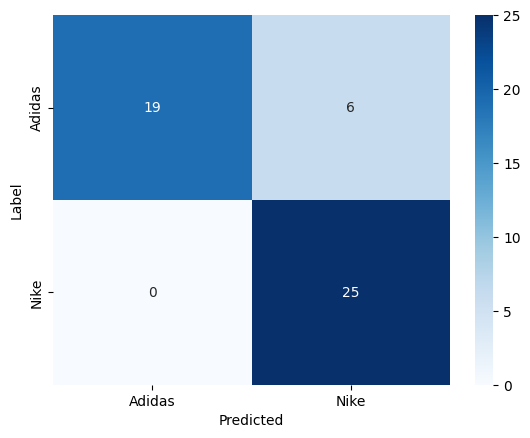

In [31]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, test_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, test_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, test_loader)

## Usabilidade de webcam

In [33]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [34]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [35]:
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')

Image: print_0.png | Resnet Prediction: Nike
Image: print_1.png | Resnet Prediction: Nike
